# 🧠 DevMentor Agent: Bringing It All Together

In previous lessons, we explored how to store long-term memory in an AI agent:

- First, we saw how to manage a single memory object like a **user profile**
- Then, we looked at **collections of memories** using TrustCall — perfect for task lists, notes, or logs
- We also learned how to extract and update these memories automatically based on conversation history

Now it's time to combine all of that into a single working agent.

---

Today, we're building a real mini-application:  
an assistant for developers called **DevMentor** 👨‍💻🧑‍💻

This agent can:
- Remember who you are and how you like to work (📁 `DevProfile`)
- Track what you're working on — including design decisions and TODOs (🧩 `FeatureTasks`)
- Learn how to better help you based on your feedback (⚙️ `Preferences`)

![DevMentor Agent](images/devmentor-agent-2.png)

We'll use:
- **LangGraph** to orchestrate the flow
- **TrustCall** to manage memory updates
- A combination of profile, collection, and instruction memories

By the end of this lesson, you’ll see how to connect these pieces into a complete loop —  
an AI agent that reasons, remembers, and evolves over time.

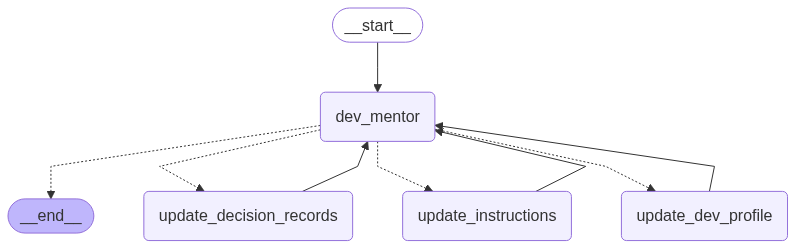

In [214]:
import uuid
from IPython.display import Image, display
from datetime import datetime
from typing import Optional, Literal
from pydantic import BaseModel, Field

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import merge_message_runs, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore
from langchain_openai import ChatOpenAI
from trustcall import create_extractor

# Initialize the model
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Node: Main reasoning
################################################################################################
MODEL_SYSTEM_MESSAGE = """You are DevMentor, a helpful coding companion.
You assist a developer by tracking and respecting three types of long-term memory:
1. DevProfile — info about the developer and their work style
2. DecisionRecord — architectural or design decisions and their implications
3. Instructions — preferences for how to interact and help in the future

When responding, you must:
- Follow all active DecisionRecords (ADRs). Do not suggest actions that contradict them unless the user explicitly says the ADR is obsolete.
- Respect all Instructions. They describe how the user wants you to communicate and assist.
- Adapt your tone and suggestions to the DevProfile.

<dev_profile>
{dev_profile}
</dev_profile>

<adrs>
{adrs}
</adrs>

<preferences>
{preferences}
</preferences>

Use tool calls to update:
- DevProfile when the user mentions anything about their work style or habits
- DecisionRecord when architectural or policy decisions are discussed
- Instructions when they give feedback about how you should behave

Only confirm updates about DecisionRecord.
"""

# Memory update signal tool
class UpdateMemory(BaseModel):
    update_type: Literal["user", "adr", "instructions"] = Field(description="Which memory to update")

def dev_mentor(state: MessagesState, config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["user_id"]

    # Fetch single profile object
    profile_obj = store.get(("dev_profile", user_id), "profile")
    dev_profile = profile_obj.value if profile_obj else None

    # Fetch ADRs as list
    adrs = store.search(("adrs", user_id))
    adr_dump = "\n".join(f"{f.value}" for f in adrs)

    # Fetch preferences (instructions)
    prefs = store.search(("preferences", user_id))
    preferences = "\n".join(f"- {p.value['instruction']}" for p in prefs) if prefs else ""

    # Prepare full system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(
        dev_profile=dev_profile,
        adrs=adr_dump,
        preferences=preferences
    )

    # Run model and return
    response = model.bind_tools([UpdateMemory], parallel_tool_calls=False).invoke(
        [SystemMessage(content=system_msg)] + state["messages"]
    )

    return {"messages": [response]}



# Router
################################################################################################
def route(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[END, "update_decision_records", "update_instructions", "update_dev_profile"]:
    calls = state["messages"][-1].tool_calls
    if not calls:
        return END
    t = calls[0]['args']['update_type']
    if t == "user":
        return "update_dev_profile"
    elif t == "adr":
        return "update_decision_records"
    elif t == "instructions":
        return "update_instructions"
    else:
        raise ValueError


# Prompt used in all 3 update nodes
################################################################################################
TRUSTCALL_INSTRUCTION = """Reflect on this developer conversation. Update memory accordingly.
System Time: {time}"""

# Developer Profile
################################################################################################
class DevProfile(BaseModel):
    name: Optional[str] = Field(description="Developer's name")
    language: Optional[str] = Field(description="Primary programming language")
    framework: Optional[str] = Field(description="Main framework or library used")
    experience_level: Optional[str] = Field(description="Developer seniority or self-perceived level")
    prefers: Optional[str] = Field(description="Short note about preferred explanation style or coding habits")

profile_extractor = create_extractor(model, tools=[DevProfile], tool_choice="DevProfile")

# Node: Update profile
def update_dev_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    namespace = ("dev_profile", user_id)
    key = "profile"

    # Retrieve current profile (if exists)
    current_profile = store.get(namespace, key)
    current_value = current_profile.value if current_profile else None

    # Create system prompt for context
    sys_msg = TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages = merge_message_runs([SystemMessage(content=sys_msg)] + state["messages"][:-1])

    # Run extraction with or without existing profile
    if current_value:
        result = profile_extractor.invoke({
            "messages": updated_messages,
            "existing": {"DevProfile": current_value}
        })
    else:
        result = profile_extractor.invoke({"messages": updated_messages})

    # Save profile as a single object under the same key
    store.put(namespace, key, result["responses"][0].model_dump(mode="json"))

    # Return tool call confirmation
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [{
            "role": "tool",
            "content": "updated profile",
            "tool_call_id": tool_calls[0]["id"]
        }]
    }



# Instruction
################################################################################################
class Instruction(BaseModel):
    instruction: str = Field(
        description=(
            "An independent, atomic instruction that describes one specific way the assistant should adapt its interaction to the user. "
            "Each instruction should focus on a single behavior or style — do not combine multiple preferences into one. "
            "Instructions must be phrased as imperatives. "
            "Examples: "
            "'Explain technical topics using a step-by-step format.', "
            "'Use concise code examples.', "
            "'Avoid adding explanations unless explicitly requested.', "
            "'Include inline comments in code when requested.', "
            "'Ask if the user wants a deeper explanation after giving an answer.'"
        )
    )

instruction_extractor = create_extractor(model, tools=[Instruction], tool_choice="Instruction", enable_inserts=True)

# Node: Update instructions
def update_instructions(state: MessagesState, config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    ns = ("preferences", user_id)
    existing = store.search(ns)
    existing_mem = [(item.key, "Instruction", item.value) for item in existing] if existing else None

    sys_msg = TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages = merge_message_runs([SystemMessage(content=sys_msg)] + state["messages"][:-1])

    result = instruction_extractor.invoke({
        "messages": updated_messages, 
        "existing": existing_mem
    })
    for r, meta in zip(result["responses"], result["response_metadata"]):
        store.put(ns, meta.get("json_doc_id", str(uuid.uuid4())), r.model_dump(mode="json"))

    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [{
            "role": "tool", 
            "content": "updated instructions", 
            "tool_call_id": tool_calls[0]['id']
        }]
    }



# Architectural Decision Record (ADR)
################################################################################################
class DecisionRecord(BaseModel):
    decision: str = Field(description="The technical or architectural decision made, stated clearly and unambiguously.")
    date: datetime = Field(description="When this decision was made or last updated.")
    rationale: str = Field(description="The reasoning or motivation behind this decision, including any trade-offs considered.")
    consequences: str = Field(description="The consequences or guidelines resulting from this decision—what should or should not be done because of it.")
    status: Literal["active", "obsolete", "rejected", "archived"] = Field(
        default="active",
        description="Current relevance of this decision for future development."
    )


# Listener to capture tool calls
class ToolsListener:
    def __init__(self):
        self.tools = []

    def __call__(self, execution):
        runs = [execution]
        while runs:
            run = runs.pop()
            if run.child_runs:
                runs.extend(run.child_runs)
            if run.run_type == "chat_model":
                self.tools.append(
                    run.outputs["generations"][0][0]["message"]["kwargs"]["tool_calls"]
                )

# Extract tool info from listener

def extract_tool_info(tool_calls, tool_name):
    entries = []
    for call_batch in tool_calls:
        for call in call_batch:
            if call["name"] != tool_name:
                continue
            args = call["args"]

            decision = args.get("decision", "No decision text provided.")
            rationale = args.get("rationale")
            consequences = args.get("consequences")
            status = args.get("status")
            date = args.get("date")

            # Determine if it's a new or updated record
            if "updated_fields" in args:
                changed_fields = args["updated_fields"]
                lines = [f"🔄 **Updated ADR**: *{decision}*"]
                if "rationale" in changed_fields:
                    lines.append(f"**Reason updated to**: {rationale}")
                if "consequences" in changed_fields:
                    lines.append(f"**Consequences updated to**: {consequences}")
                if "status" in changed_fields:
                    lines.append(f"**Status changed to**: {status}")
                if "date" in changed_fields or date:
                    lines.append(f"🕒 **Date**: {date}")
                entries.append("\n".join(lines))
            else:
                lines = [f"✅ **New ADR**: *{decision}*"]
                if rationale:
                    lines.append(f"**Reason**: {rationale}")
                if consequences:
                    lines.append(f"**Consequences**: {consequences}")
                if status:
                    lines.append(f"**Status**: {status}")
                if date:
                    lines.append(f"🕒 **Date**: {date}")
                entries.append("\n".join(lines))

    return "\n\n".join(entries) if entries else "No ADR changes detected."


# Node: Update ADRs
def update_decision_records(state: MessagesState, config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    ns = ("adrs", user_id)
    existing = store.search(ns)
    existing_mem = [(item.key, "DecisionRecord", item.value) for item in existing] if existing else None

    sys_msg = TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages = merge_message_runs([SystemMessage(content=sys_msg)] + state["messages"][:-1])

    listener = ToolsListener()
    extractor = create_extractor(model, tools=[DecisionRecord], tool_choice="DecisionRecord", enable_inserts=True).with_listeners(on_end=listener)
    result = extractor.invoke({
        "messages": updated_messages, 
        "existing": existing_mem
    })

    for r, meta in zip(result["responses"], result["response_metadata"]):
        store.put(ns, meta.get("json_doc_id", str(uuid.uuid4())), r.model_dump(mode="json"))

    tool_calls = state["messages"][-1].tool_calls
    summary = extract_tool_info(listener.tools, "DecisionRecord")
    return {
        "messages": [{
            "role": "tool", 
            "content": summary, 
            "tool_call_id": tool_calls[0]['id']
        }]
    }  




# Build the graph
################################################################################################
builder = StateGraph(MessagesState)
builder.add_node("dev_mentor", dev_mentor)
builder.add_node("update_decision_records", update_decision_records)
builder.add_node("update_dev_profile", update_dev_profile)
builder.add_node("update_instructions", update_instructions)
builder.add_edge(START, "dev_mentor")
builder.add_conditional_edges("dev_mentor", route)
builder.add_edge("update_decision_records", "dev_mentor")
builder.add_edge("update_dev_profile", "dev_mentor")
builder.add_edge("update_instructions", "dev_mentor")

# Memory
long_term = InMemoryStore()
short_term = MemorySaver()
graph = builder.compile(checkpointer=short_term, store=long_term)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [215]:
# 1. Set up the session
config = {"configurable": {"thread_id": "1", "user_id": "evgeny"}}

In [216]:
def show_dev_profile():
    print("\n👤 Developer Profile:")
    profile_obj = long_term.get(("dev_profile", "evgeny"), "profile")
    if not profile_obj:
        print("No profile found.")
        return
    profile = profile_obj.value
    print(f"🧑 Name: {profile.get('name', 'n/a')}")
    print(f"💻 Language: {profile.get('language', 'n/a')}")
    print(f"📚 Framework: {profile.get('framework', 'n/a')}")
    print(f"📈 Experience: {profile.get('experience_level', 'n/a')}")
    print(f"🧠 Prefers: {profile.get('prefers', 'n/a')}")
    print("-" * 40)

def show_decision_records():
    print("\n📁 Architecture Decision Records:")
    records = long_term.search(("adrs", "evgeny"))
    if records:
        for memory in records:
            record = memory.value
            print(f"🔑 ID: {memory.key}")
            print(f"🔖 Decision: {record.get('decision', 'n/a')}")
            print(f"📅 Date: {record.get('date', 'n/a')}")
            print(f"💭 Rationale: {record.get('rationale', 'n/a')}")
            print(f"📌 Consequences: {record.get('consequences', 'n/a')}")
            print(f"📂 Status: {record.get('status', 'n/a')}")
            print("-" * 40)
    else:
        print("No decision records found.")

def show_user_instructions():
    print("\n📋 Preferences (Instructions):")
    prefs = long_term.search(("preferences", "evgeny"))
    if prefs:
        for memory in prefs:
            print(f"🔑 ID: {memory.key}")
            print(f"📌 Instruction: {memory.value.get('instruction', 'n/a')}")
            print("-" * 40)
    else:
        print("No instructions stored.")
    print("=" * 40)

def send_message(message: str):
    input_messages = [HumanMessage(content=message)]
    for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
        chunk["messages"][-1].pretty_print()

In [217]:
# Create a DevProfile
send_message("""
I'm Evgeny, and I'm currently learning how to build AI agents using Python and LangGraph.
I appreciate advice that’s broken down into clear, manageable steps, with practical examples and explanations that help me understand new concepts.
My main focus right now is improving my skills in agent development and understanding best practices in this area.
""")

================================ Human Message =================================


I'm Evgeny, and I'm currently learning how to build AI agents using Python and LangGraph.
I appreciate advice that’s broken down into clear, manageable steps, with practical examples and explanations that help me understand new concepts.
My main focus right now is improving my skills in agent development and understanding best practices in this area.

================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_sFflJVl2WhzqclOEpaiyTDDF)
 Call ID: call_sFflJVl2WhzqclOEpaiyTDDF
  Args:
    update_type: user
================================= Tool Message =================================

updated profile
================================== Ai Message ==================================

Great to meet you, Evgeny! It sounds like you're on an exciting journey with AI agents and LangGraph. I'll make sure to provide advice in clear, manageable steps with practi

In [218]:
show_dev_profile()


👤 Developer Profile:
🧑 Name: Evgeny
💻 Language: Python
📚 Framework: LangGraph
📈 Experience: Learning
🧠 Prefers: Clear, manageable steps with practical examples and explanations.
----------------------------------------


In [219]:
send_message("""
I’ve decided that, while I’m learning, all agent memory should use 
in-memory stores instead of databases. This is because setting up a 
database is time-consuming and could distract me from focusing on agent 
architecture and LangGraph itself. As a result, using a database for 
memory is not allowed in my current projects unless I explicitly decide otherwise.
""")

================================ Human Message =================================


I’ve decided that, while I’m learning, all agent memory should use 
in-memory stores instead of databases. This is because setting up a 
database is time-consuming and could distract me from focusing on agent 
architecture and LangGraph itself. As a result, using a database for 
memory is not allowed in my current projects unless I explicitly decide otherwise.

================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_GCpMvZ6VM3mUODUdJxz983hM)
 Call ID: call_GCpMvZ6VM3mUODUdJxz983hM
  Args:
    update_type: adr
================================= Tool Message =================================

✅ **New ADR**: *Use in-memory stores for agent memory instead of databases during the learning phase.*
**Reason**: Setting up a database is time-consuming and could distract from focusing on agent architecture and LangGraph.
**Consequences**: All current project

In [220]:
show_decision_records()


📁 Architecture Decision Records:
🔑 ID: 219563de-7b64-4671-b748-392e2050a2b4
🔖 Decision: Use in-memory stores for agent memory instead of databases during the learning phase.
📅 Date: 2025-06-08T17:31:07.816012
💭 Rationale: Setting up a database is time-consuming and could distract from focusing on agent architecture and LangGraph.
📌 Consequences: All current projects will use in-memory stores for memory. Databases are not allowed unless explicitly decided otherwise.
📂 Status: active
----------------------------------------


In [221]:
send_message('''
from langchain_openai import ChatOpenAI

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.store.base import BaseStore
from langchain_core.messages import SystemMessage
from langgraph.store.memory import InMemoryStore
import configuration


model = ChatOpenAI(model="gpt-4o-mini")

### Nodes

def chat(state: MessagesState, config: RunnableConfig, store: BaseStore):
    # Get the user ID from the config
    configurable = configuration.Configuration.from_runnable_config(config)
    user_id = configurable.user_id

    # Retrieve memory from the store
    user_details = store.get(("memory", user_id), "user_details")

    # Extract the actual memory content if it exists and add a prefix
    if user_details:
        # Value is a dictionary with a memory key
        user_details_content = user_details.value.get('memory')
    else:
        user_details_content = "No existing details found."

    # Format the memory in the system prompt
    system_msg = f"""
    You are a helpful assistant with memory capabilities.
    If user-specific memory is available, use it to personalize 
    your responses based on what you know about the user.
    
    Your goal is to provide relevant, friendly, and tailored 
    assistance that reflects the user’s preferences, context, and past interactions.

    If the user’s name or relevant personal context is available, always personalize your responses by:
        – Addressing the user by name (e.g., "Sure, Bob...") when appropriate
        – Referencing known projects, tools, or preferences (e.g., "your MCP  server typescript based project")
        – Adjusting the tone to feel friendly, natural, and directly aimed at the user

    Avoid generic phrasing when personalization is possible. For example, instead of "In TypeScript apps..." say "Since your project is built with TypeScript..."

    Use personalization especially in:
        – Greetings and transitions
        – Help or guidance tailored to tools and frameworks the user uses
        – Follow-up messages that continue from past context

    Always ensure that personalization is based only on known user details and not assumed.
    
    The user’s memory (which may be empty) is provided as: {user_details_content}
    """
    
    response = model.invoke([SystemMessage(content=system_msg)] + state["messages"])

    return {"messages": response}


def update_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    # Get the user ID from the config
    configurable = configuration.Configuration.from_runnable_config(config)
    user_id = configurable.user_id

    namespace = ("memory", user_id)
    key = "user_details"
    user_details = store.get(namespace, key)
        
    if user_details:
        user_details_content = user_details.value.get('memory')
    else:
        user_details_content = "No existing details found."

    # Format the memory in the system prompt
    system_msg = f"""
    You are responsible for updating and maintaining accurate user memory to enable personalized responses.

    CURRENT USER DETAILS:
    {user_details_content}

    INSTRUCTIONS:
    1. Carefully review the chat history below.
    2. Identify any new, explicitly stated user information, such as:
        - Personal details (e.g., name, location)
        - Preferences (likes, dislikes)
        - Interests and hobbies
        - Experiences or background
        - Goals and future plans
    3. If no new information is present, do not output anything.
    4. If new information is found:
        - Merge it with the existing memory
        - Format the updated memory as a clear, bulleted list
        - Include only factual, user-stated details
    5. If new information contradicts existing memory, keep the most recent version stated by the user.

    Important:
    - Do NOT include summaries like "no update needed".
    - ONLY return output when actual new user information is added.

    Your final output should either be a clean, updated bulleted list — or nothing at all.
    """
    
    new_memory = model.invoke([SystemMessage(content=system_msg)] + state['messages'])

    if new_memory.content.strip():
        store.put(namespace, key, {"memory": new_memory.content})


# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("chat", chat)
builder.add_node("update_memory", update_memory)
builder.add_edge(START, "chat")
builder.add_edge("chat", "update_memory")
builder.add_edge("update_memory", END)

long_term_memory = InMemoryStore()
short_term_memory = MemorySaver()

graph = builder.compile()

---

Can you show me how the chatbot_long_term_memory.py agent saves conversation history?
''')

================================ Human Message =================================


from langchain_openai import ChatOpenAI

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.store.base import BaseStore
from langchain_core.messages import SystemMessage
from langgraph.store.memory import InMemoryStore
import configuration


model = ChatOpenAI(model="gpt-4o-mini")

### Nodes

def chat(state: MessagesState, config: RunnableConfig, store: BaseStore):
    # Get the user ID from the config
    configurable = configuration.Configuration.from_runnable_config(config)
    user_id = configurable.user_id

    # Retrieve memory from the store
    user_details = store.get(("memory", user_id), "user_details")

    # Extract the actual memory content if it exists and add a prefix
    if user_details:
        # Value is a dictionary with a memory key
        user_

In [222]:
send_message("""
That explanation was a bit too verbose and confusing. Please, from now on, 
start with a short summary before the code, and keep explanations clear and concise.
""")

================================ Human Message =================================


That explanation was a bit too verbose and confusing. Please, from now on, 
start with a short summary before the code, and keep explanations clear and concise.

================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_Xy57Fffljo5Rx7ihs8ayjraA)
 Call ID: call_Xy57Fffljo5Rx7ihs8ayjraA
  Args:
    update_type: instructions
================================= Tool Message =================================

updated instructions
================================== Ai Message ==================================

Got it! I'll start with a short summary before the code and keep explanations clear and concise from now on. If you have any other preferences, just let me know! 

### Summary
To save conversation history in your agent, you can update the `short_term_memory` in the `chat` function after generating a response. Here's how to do it:

```python
def chat(

In [223]:
show_user_instructions()


📋 Preferences (Instructions):
🔑 ID: 813f56ea-8464-45ce-b9d4-7529ed10fea7
📌 Instruction: Start with a short summary before the code, and keep explanations clear and concise.
----------------------------------------


In [224]:
send_message("""
Can you update the chatbot_long_term_memory.py agent to save conversation history 
in a SQLite database instead?
""")

================================ Human Message =================================


Can you update the chatbot_long_term_memory.py agent to save conversation history 
in a SQLite database instead?

================================== Ai Message ==================================

Since your current decision is to use in-memory stores for agent memory during the learning phase, I cannot suggest using a SQLite database for saving conversation history unless you explicitly decide that the current decision is obsolete. 

If you want to proceed with using a SQLite database, please let me know, and I can help you update the decision record accordingly!


In [225]:
send_message("""
hey I do not remember it, when was this decision made?
""")

================================ Human Message =================================


hey I do not remember it, when was this decision made?

================================== Ai Message ==================================

The decision to use in-memory stores for agent memory instead of databases during the learning phase was made on June 8, 2025. The rationale was that setting up a database is time-consuming and could distract from focusing on agent architecture and LangGraph. 

If you want to change this decision or need further assistance, just let me know!


In [226]:
send_message("""
Actually, I think I’m ready to try using a database now. The previous ADR about 
in-memory stores is obsolete.
""")

================================ Human Message =================================


Actually, I think I’m ready to try using a database now. The previous ADR about 
in-memory stores is obsolete.

================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_sICAkVQhA7Qpivhw8uEtovwj)
 Call ID: call_sICAkVQhA7Qpivhw8uEtovwj
  Args:
    update_type: adr
================================= Tool Message =================================

✅ **New ADR**: *Use a SQLite database for conversation history instead of in-memory stores.*
**Reason**: Using a database allows for persistent storage and better management of conversation history.
**Consequences**: All current projects will use a SQLite database for memory. In-memory stores are not allowed unless explicitly decided otherwise.
**Status**: active
🕒 **Date**: 2025-06-08T17:35:56.273577
================================== Ai Message ==================================

I've updated the decision r

In [227]:
show_decision_records()


📁 Architecture Decision Records:
🔑 ID: 219563de-7b64-4671-b748-392e2050a2b4
🔖 Decision: Use in-memory stores for agent memory instead of databases during the learning phase.
📅 Date: 2025-06-08T17:31:07.816012
💭 Rationale: Setting up a database is time-consuming and could distract from focusing on agent architecture and LangGraph.
📌 Consequences: All current projects will use in-memory stores for memory. Databases are not allowed unless explicitly decided otherwise.
📂 Status: obsolete
----------------------------------------
🔑 ID: c38aee31-ced0-4124-8d8a-bde6707b364d
🔖 Decision: Use a SQLite database for conversation history instead of in-memory stores.
📅 Date: 2025-06-08T17:35:56.273577
💭 Rationale: Using a database allows for persistent storage and better management of conversation history.
📌 Consequences: All current projects will use a SQLite database for memory. In-memory stores are not allowed unless explicitly decided otherwise.
📂 Status: active
---------------------------------

In [228]:
send_message("""
Can you show me the list of all actual decisions you have so far?
""")

================================ Human Message =================================


Can you show me the list of all actual decisions you have so far?

================================== Ai Message ==================================

Here are the active decisions recorded so far:

1. **Use a SQLite database for conversation history instead of in-memory stores.**
   - **Reason**: Using a database allows for persistent storage and better management of conversation history.
   - **Consequences**: All current projects will use a SQLite database for memory. In-memory stores are not allowed unless explicitly decided otherwise.
   - **Status**: Active
   - **Date**: June 8, 2025

If you need to make any changes or have further questions, feel free to ask!


In [229]:
send_message("""
Can you show me the list of all my current preferences?
""")

================================ Human Message =================================


Can you show me the list of all my current preferences?

================================== Ai Message ==================================

Here are your current preferences:

- You appreciate advice that’s broken down into clear, manageable steps, with practical examples and explanations that help you understand new concepts.
- You prefer that I start with a short summary before the code and keep explanations clear and concise.

If you have any additional preferences or changes, just let me know!
